In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

np.set_printoptions(suppress=True)

import bayesflow as bf
import tensorflow as tf

from functools import partial
from numba import njit

from bayesflow.simulation import (
    TwoLevelPrior, 
    Simulator, 
    TwoLevelGenerativeModel
)
from bayesflow.helper_networks import ConfigurableMLP

In [4]:
@njit
def sigmoid(x):
    return 1. / (1. + np.exp(-x))


In [5]:
param_names = [r"$r$", r"$\mu_v$"]

In [42]:
#@njit
def hyper_prior_fun():
    """
    Sample prior parameters for the agent group, 
    i.e., base scale of sensing radius (r) and walking speed (v). 
    
    Returns
    -------
    Sampled priors as a NumPy array.
    """
    
    # Bounding using Sigmoid
    # z_r = np.random.normal(0., 1.)
    # r = sigmoid(z_r)
    
    # Hypermean for velocity
    mu_v = np.random.normal(0., 1.)
    
    return np.array([mu_v], dtype=np.float32)

In [43]:
#@njit
def local_prior_fun(mu_v):
    
    v = sigmoid(np.random.normal(mu_v, 1))
    
    return np.array([v], dtype=np.float32)

#@njit
def share_prior_fun():
    
    r = sigmoid(np.random.normal(0., 1.))
    
    return np.array([r], dtype=np.float32)

In [39]:
#@njit
def prior_fun(num_agents: int = 12):
    
    # Unpack hypers
    hypers = hyper_prior_fun()
    mu_v, r = hypers[0], hypers[1]
    
    # Sample individual radii and velocities (they will now be different)
    theta = np.empty((num_agents, 2), dtype=np.float32)
    
    for i in range(num_agents):
        theta[i, 0] = r
        theta[i, 1] = sigmoid(np.random.normal(mu_v, 1))  
    
    

In [45]:
test_prior = TwoLevelPrior(
    hyper_prior_fun=hyper_prior_fun, 
    local_prior_fun=local_prior_fun,
    shared_prior_fun=share_prior_fun
)

f = bf.simulation.plot_prior2d(prior=test_prior, param_names=param_names)

KeyError: 'prior_draws'

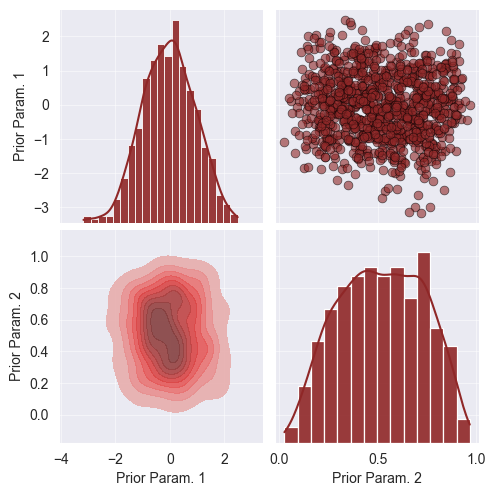

In [8]:
test_prior = Prior(prior_fun=hyperprior_fun, param_names=param_names)
f = bf.simulation.plot_prior2d(test_prior, n_samples=1000)

In [10]:
@njit
def initialize_agents(
    num_agents = 12,
    boundary_size = 10.,
):
    """
    Initialize agent positions and directions.
    
    Parameters
    ----------
    num_agents      : int, default: 12
        Number of agents to initialize. 
    boundary_size   : float, default: 10.0
        Size of the boundary (in meters).
    
    Returns
    -------
    positions      : np.ndarray of shape (num_agents, 2)
        Initial positions of the agents.
    directions      : np.ndarray of shape (num_agents, )
        Initial directions of the agents. 
    """
    
    positions = np.random.random(size=(num_agents, 2)).astype(np.float32) * boundary_size
    directions = np.random.random(size=num_agents) * 2 * np.pi
    
    # Unpack hypers
    hypers = hyperprior_fun()
    mu_v, r = hypers[0], hypers[1]
    
    # Sample individual radii and velocities (they will now be different)
    theta = np.empty((num_agents, 2), dtype=np.float32)
    
    for i in range(num_agents):
        theta[i, 0] = r
        theta[i, 1] = sigmoid(np.random.normal(mu_v, 1))      
    
    return positions, directions, theta, hypers

In [24]:
@njit
def simulator_fun(
    theta,
    num_agents=12,
    num_timesteps=100,
    boundary_size=10.0,
):
    """
    Simulate the movement trajectory of the agent, 
    as governed by the Vicsek model.
    
    Parameters
    ----------
    theta : np.ndarray of shape (2, )
        Sampled priors for the model, including the 
        base sensing radius (r) and walking speed (v)
        of the agents.
    num_agents     : int, default: 12
        Number of agents to simulate.
    num_timesteps   : int, default: 100
        Number of timesteps to simulate.
    boundary_size   : float, default: 10.0
        Size of the simulation boundary (in meters).
    
    Returns
    -------
    A concatenated NumPy array of combined trajectory 
    and direction of the agents as timeseries.
    """

    
    # Initialize positions and directions for each agent
    positions, directions, theta, hypers = initialize_agents(num_agents, boundary_size)
    
    r, v = theta[:, 0], theta[:, 1]
    
    # Scale radius with half of boundary size (for realism)
    radius = r * boundary_size * 0.5

    # Store trajectories and headings
    paths = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))


    paths[0] = positions
    headings[0] = directions[:, np.newaxis]

    # Loop over each timestep
    for t in range(num_timesteps):
        # For each timestep, initialize directions for the agents
        new_directions = np.zeros(num_agents)
        
        # For each agent, collect neighbors within its sensing range
        for i in range(num_agents):
            
            neighbors = []
            # If there are any neighbors, average over their directions 
            # and assign it as the new direction. 
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius[0]:
                    neighbors.append(directions[j])
            if neighbors:
                # This is incorrect, because of wrap-around radians.
                # avg_direction = np.mean(np.array(neighbors))
                
                # This is correct
                # Separate the direction into Cartesian components
                dir_x = np.cos(directions)
                dir_y = np.sin(directions)
                # Averaging the direction
                avg_dir_x = np.mean(dir_x)
                avg_dir_y = np.mean(dir_y)
                # Convert the direction back to radians
                avg_direction = np.arctan2(avg_dir_y, avg_dir_x)
                
                new_directions[i] = avg_direction + np.random.uniform(-0.01, 0.01)
            else:
                new_directions[i] = directions[i]

        directions = np.copy(new_directions)
            
            # Update position upon new direction
        positions[:,0] += v * np.cos(directions)
        positions[:,1] += v * np.sin(directions)
        
        # Assumes periodic boundary condition (for now)
        positions = np.mod(np.copy(positions), boundary_size)

        # Add timestamps to trajectories and headings
        paths[t + 1] = np.copy(positions)
        headings[t + 1] = np.copy(directions[:, np.newaxis])

    return np.concatenate((paths, headings), axis=-1)

In [25]:
prior = Prior(prior_fun=hyperprior_fun)

simulator = Simulator(simulator_fun=simulator_fun)

model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Vicsek")

INFO:root:Performing 2 pilot runs with the Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [19]:
def configurator(input_dict: dict = None, transpose: bool = True):
    
    output_dict = {}
    output_dict['parameters'] = input_dict['prior_draws'].astype(np.float32)
    x = input_dict['sim_data'] / 10. 
    if transpose:
        x = np.transpose(x, (0, 2, 1, 3))
    output_dict['summary_conditions'] = x.astype(np.float32)
    return output_dict

In [20]:
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(units=128)),
    bf.networks.SetTransformer(num_inducing_points=None, input_dim=128, summary_dim=64)
])

inference_net = bf.helper_networks.ConfigurableMLP(
    input_dim=2, 
    num_hidden=5,
    dropout_rate=0.0
)

amortizer = bf.amortizers.AmortizedPointEstimator(
    summary_net=summary_net, inference_net=inference_net
)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [21]:
history = trainer.train_online(epochs=5, batch_size=32, iterations_per_epoch=500)

Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 